# Learning Asymmetry With a Neural Network

The title is self-explanatory. The purpose of this notebook is for me to practice using PyTorch's neural network and optimization packages. 

## Define the data/labels

The input to our network is going to be all binary numbers with six digits. 

In [1]:
def fill_binary_numbers(arr):
    """Fills 2-d numpy array with binary numbers, counting upwards from 0, 1, 10, 11, etc."""
    for power in range(0, arr.shape[1]):
        for i in range(0, arr.shape[0]):
            arr[i, arr.shape[1] - power - 1] = int(i/(2**power)) % 2

import numpy
import torch
import torch.autograd as autograd

inputs = numpy.zeros((64, 6)).astype("float32")
fill_binary_numbers(inputs.data)
labels = numpy.all(numpy.equal(inputs[:,0:3], inputs[:,5:2:-1]), axis=1).astype("float32")

inputs = autograd.Variable(torch.from_numpy(inputs))
labels = autograd.Variable(torch.from_numpy(labels))

Now we'll go ahead and define our neural network: a two-layer neural net with two hidden units and sigmoid activation functions in the intermediate layer. The final layer will be have an absolute value activation function (important: this is chosen because it is required for the network to learn the desired function with the given architecture; it is ad hoc). 

In [2]:
import torch.nn as nn
import torch.nn.functional as functional

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.l1_linear = nn.Linear(6, 2)
        self.l2_linear = nn.Linear(2, 1)
    
    def forward(self, x):
        x = functional.sigmoid(self.l1_linear(x))
        x = torch.abs(self.l2_linear(x))
        return x

net = SimpleNet()
print(net)

SimpleNet (
  (l1_linear): Linear (6 -> 2)
  (l2_linear): Linear (2 -> 1)
)


Let's train the network now, using stochastic gradient descent with momentum. 

In [3]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
loss = nn.MSELoss(size_average=False)
for i in range(1000):
    outputs = net(inputs)
    error = loss(outputs, labels)
    net.zero_grad()
    error.backward()
    optimizer.step()

Hopefully that worked. Let's check the final error, and examine a sample of the input/output pairs.

In [4]:
print(outputs.data.type(), outputs.data.size())
print(labels.data.type(), labels.data.unsqueeze(1).size())
print(torch.cat((outputs.data, labels.data.unsqueeze(1)), dim=1))

torch.FloatTensor torch.Size([64, 1])
torch.FloatTensor torch.Size([64, 1])

  nan     1
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     1
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     1
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     1
  nan     0
  nan     0
  nan     1
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     1
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     1
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     0
  nan     1
[torch.FloatTensor of size 64x2]



Oh no! Everything is `nan`. Why is this the case? Let's redo that (and put it in a function, in case we have to do this over again), but just for a couple iterations, and plot what happens to the norm of the weights and gradients over time, to see what's happening. 

[3.1938954673951017, 39.707759792941715, 369.856304958248, 3977.21367543412, 43014.83130407993]
[32.5146058552451, 446.57187869333455, 4350.955976469997, 47063.69531437877, 509017.7187500079]


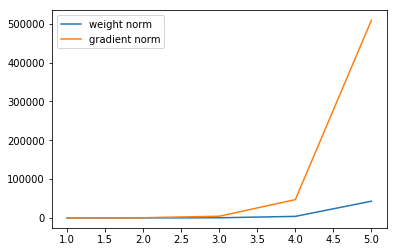

In [5]:
import matplotlib.pyplot as pyplot
%matplotlib inline

def norm(seq):
    """Takes a sequence of torch.FloatTensor's and returns the norm of
    all elements contained in them."""
    def get_flat_size(tensor):
        fs = 1
        for s in tensor.size():
            fs *= s
        return fs
    return torch.norm(torch.cat([t.view(get_flat_size(t)) for t in seq]))

def train(net, num_steps):
    weight_norms = []
    gradient_norms = []
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    loss = nn.MSELoss(size_average=False)
    for i in range(num_steps):
        outputs = net(inputs)
        error = loss(outputs, labels)
        net.zero_grad()
        error.backward()
        optimizer.step()
        weight_norms.append(norm([p.data for p in net.parameters()]))
        gradient_norms.append(norm([p.grad.data for p in net.parameters()]))
    return (weight_norms, gradient_norms)

num_epochs = 5
wnorms, gnorms = train(SimpleNet(), num_epochs)
print(wnorms)
print(gnorms)
pyplot.plot(range(1, num_epochs + 1), wnorms)
pyplot.plot(range(1, num_epochs + 1), gnorms)
pyplot.legend(['weight norm', 'gradient norm'])

From debugging the above, I learned that the `data` property of an `autograd.Variable` instance is a `torch.Tensor`, while the `grad` property is another `autograd.Variable`. 

In any case, it looks like the weights are going up...and up...and up. Something must be wonky with the optimization, or with the problem itself. Let's try limiting the weight size by adding a regularization term to the error function. 

[1333.1727022064015, 1342149.6111541574, 1346303111.392663, 1355844869018.1504, 1360448394782056.2]
[13345.012077266509, 13446837.09037436, 13488543164.995909, 13584039355255.83, 1.3630255970018532e+16]


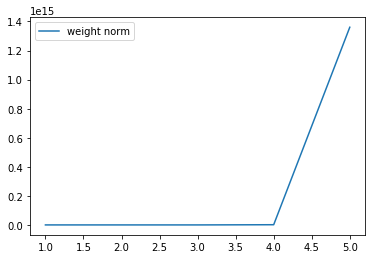

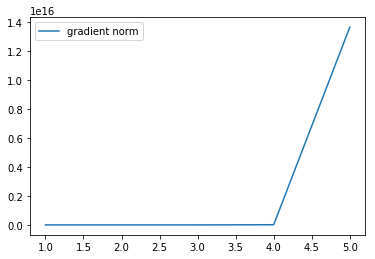

In [6]:
def train_with_weight_decay(net, num_steps):
    weight_norms = []
    gradient_norms = []
    optimizer = optim.SGD(
        net.parameters(), lr=0.1, momentum=0.9, weight_decay=10000.0)
    loss = nn.MSELoss(size_average=False)
    for i in range(num_steps):
        outputs = net(inputs)
        error = loss(outputs, labels)
        net.zero_grad()
        error.backward()
        optimizer.step()
        weight_norms.append(norm([p.data for p in net.parameters()]))
        gradient_norms.append(norm([p.grad.data for p in net.parameters()]))
    return (weight_norms, gradient_norms)

num_epochs = 5
wnorms, gnorms = train_with_weight_decay(SimpleNet(), num_epochs)
print(wnorms)
print(gnorms)
pyplot.plot(range(1, num_epochs + 1), wnorms)
pyplot.legend(['weight norm'])
pyplot.figure()
pyplot.plot(range(1, num_epochs + 1), gnorms)
pyplot.legend(['gradient norm'])

Okay. So, as you can see, there is a very big problem here. The weight decay does not stop it--at all. Maybe it's an architectural problem. The reason I chose the absolute value activation function is because, in the solution from the original paper by Rumelhart et al. (1986), the solution learned by their network seems to require a non-sigmoid activation function--or else the labels are different. 

In fact, they did not mention explicitly what the label values were. It could be that they engineered the label functions to make the network learn a good representation. 

In any case, let's try the absolute value of the sigmoid, so that the output (and, therefore, the gradient) is bounded. This should change our graphs. 

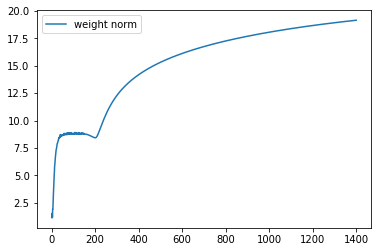

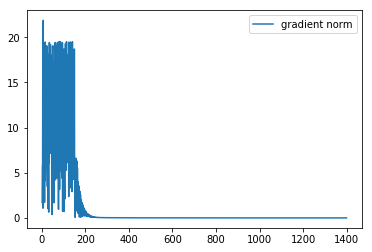

In [7]:
class SimpleNetV2(nn.Module):
    def __init__(self):
        super(SimpleNetV2, self).__init__()
        
        self.l1_linear = nn.Linear(6, 2)
        self.l2_linear = nn.Linear(2, 1)
    
    def forward(self, x):
        x = functional.sigmoid(self.l1_linear(x))
        x = torch.abs(functional.sigmoid(self.l2_linear(x))*2 - 1)
        return x

num_epochs = 1400
net = SimpleNetV2()
wnorms, gnorms = train(net, num_epochs)
pyplot.plot(range(1, num_epochs + 1), wnorms)
pyplot.legend(['weight norm'])
pyplot.figure()
pyplot.plot(range(1, num_epochs + 1), gnorms)
pyplot.legend(['gradient norm'])

Alright! So this fixed the problem with exploding gradients and, as a result (or so it seems), our exploding weights!

Now let's check how our predictions fair against the training labels. 

In [8]:
outputs = net(inputs)
print(outputs.data.type(), outputs.data.size())
print(labels.data.type(), labels.data.unsqueeze(1).size())
print(torch.cat((outputs.data, labels.data.unsqueeze(1)), dim=1))

torch.FloatTensor torch.Size([64, 1])
torch.FloatTensor torch.Size([64, 1])

 0.9601  1.0000
 0.1143  0.0000
 0.1143  0.0000
 0.1108  0.0000
 0.1143  0.0000
 0.1108  0.0000
 0.1108  0.0000
 0.1109  0.0000
 0.1141  0.0000
 0.1107  0.0000
 0.1107  0.0000
 0.1109  0.0000
 0.1107  1.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1144  0.0000
 0.1108  0.0000
 0.1108  1.0000
 0.1109  0.0000
 0.1108  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1108  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  1.0000
 0.1109  0.0000
 0.1142  0.0000
 0.1108  1.0000
 0.1108  0.0000
 0.1109  0.0000
 0.1108  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1107  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  1.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1108  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  1.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.0000
 0.1109  0.

Okay...it's not entirely clear what's going on--that is, I don't understand why it's not learning the function as intended. Let's check the weights themselves. 

In [9]:
print(net.l1_linear.weight.data)
print(net.l1_linear.bias.data)
print(net.l2_linear.weight.data)
print(net.l2_linear.bias.data)


-6.7320 -6.7312 -6.7321 -6.7323 -6.7310 -6.7321
-1.8430 -2.1063 -1.6858 -1.9522 -1.8903 -1.9100
[torch.FloatTensor of size 2x6]


-0.0401
-4.0192
[torch.FloatTensor of size 2]


 7.5154 -0.6593
[torch.FloatTensor of size 1x2]


 0.2227
[torch.FloatTensor of size 1]



Okay, my mistake. After looking at the paper, it seems that they label "on" (i.e., positive) output to indicate symmetry. Let's update this. 

In [10]:
labels.data = 1.0 - labels.data

net = SimpleNetV2()
train(net, 1400)
outputs = net(inputs)
print(outputs.data.type(), outputs.data.size())
print(labels.data.type(), labels.data.unsqueeze(1).size())
print(torch.cat((outputs.data, labels.data.unsqueeze(1)), dim=1))

torch.FloatTensor torch.Size([64, 1])
torch.FloatTensor torch.Size([64, 1])

    1     0
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     0
    1     1
    1     1
    1     1
    1     1
    1     1
    1     0
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     0
    1     1
    1     1
    1     0
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     0
    1     1
    1     1
    1     1
    1     1
    1     1
    1     0
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     1
    1     0
[torch.FloatTensor of size 64x2]



Okay, that's it. I only have so much time. This will haunt me forever, but I must leave it be for now. 

BAH! Fine. I forgot to use a sigmoid at the end, as (it seems) they did in the original paper. Let us see how this works now. 

In [11]:
class SimpleNetV3(nn.Module):
    def __init__(self):
        super(SimpleNetV3, self).__init__()
        
        self.l1_linear = nn.Linear(6, 2)
        self.l2_linear = nn.Linear(2, 1)
    
    def forward(self, x):
        x = functional.sigmoid(self.l1_linear(x))
        x = functional.sigmoid(self.l2_linear(x))
        return x

net = SimpleNetV3()
train(net, 1400)
outputs = net(inputs)
print(outputs.data.type(), outputs.data.size())
print(labels.data.type(), labels.data.unsqueeze(1).size())
print(torch.cat((outputs.data, labels.data.unsqueeze(1)), dim=1))

torch.FloatTensor torch.Size([64, 1])
torch.FloatTensor torch.Size([64, 1])

 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  0.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.0000
 1.0000  1.

Okay. Now I'm really done. 

## JUST KIDDING LET'S DO THIS

So I figured out (several hours later, after looking at the paper and directly implementing their exactly network instance to be sure) that this is what they did:
* labels are 1 for symmetrical inputs, and 0 for asymmetrical inputs;
* they did, indeed, use sigmoids everywhere (no funky stuff necessary!).

Let's do *exactly* what they did now. 

In [42]:
inputs = numpy.zeros((64, 6)).astype("float32")
fill_binary_numbers(inputs)
labels = numpy.logical_not(numpy.all(numpy.equal(inputs[:,0:3], inputs[:,5:2:-1]), axis=1)).astype("float32")

inputs = autograd.Variable(torch.from_numpy(inputs))
labels = autograd.Variable(torch.from_numpy(labels))

print(torch.cat([inputs, labels.unsqueeze(1)], 1)[10:20, :])

Variable containing:
    0     0     1     0     1     0     1
    0     0     1     0     1     1     1
    0     0     1     1     0     0     0
    0     0     1     1     0     1     1
    0     0     1     1     1     0     1
    0     0     1     1     1     1     1
    0     1     0     0     0     0     1
    0     1     0     0     0     1     1
    0     1     0     0     1     0     0
    0     1     0     0     1     1     1
[torch.FloatTensor of size 10x7]



In [55]:
class FinalNet(nn.Module):
    def __init__(self):
        super(FinalNet, self).__init__()
        self.l1_linear = nn.Linear(6, 3)
        self.l2_linear = nn.Linear(3, 1)
    
    def forward(self, x):
        x = functional.sigmoid(self.l1_linear(x))
        x = functional.sigmoid(self.l2_linear(x))
        return x

import torch.nn.init as init
def uniform(module, a=-0.3, b=0.3):
    if module.__class__.__name__ == 'Linear':
        init.uniform(module.weight.data)
        init.uniform(module.bias.data)

net = FinalNet()
net.apply(uniform)
print(net(autograd.Variable(torch.Tensor([1, 0, 0, 0, 0, 1]).unsqueeze(0))))

Variable containing:
 0.9027
[torch.FloatTensor of size 1x1]



In [56]:
import random

symmetric_inputs_numpy = inputs.data.numpy()[labels.data.numpy() == 0.]
asymmetric_inputs_numpy = inputs.data.numpy()[labels.data.numpy() == 1.]

def balanced_random_choice():
    numpy.random.shuffle(asymmetric_inputs_numpy)
    current_inputs_numpy = numpy.concatenate(
        (symmetric_inputs_numpy, asymmetric_inputs_numpy[0:8, :]))
    current_labels_numpy = numpy.concatenate(
        [numpy.ones((8,), dtype=numpy.float32), numpy.zeros((8,), dtype=numpy.float32)])
    
    indexes = numpy.random.permutation(current_inputs_numpy.shape[0])
    current_inputs_numpy = current_inputs_numpy[indexes, :]
    current_labels_numpy = current_labels_numpy[indexes]
    
    return (autograd.Variable(torch.from_numpy(current_inputs_numpy)),
            autograd.Variable(torch.from_numpy(current_labels_numpy)))

print(balanced_random_choice())

(Variable containing:
    1     0     1     0     0     0
    0     1     1     0     0     0
    1     0     0     0     0     1
    0     0     0     0     0     1
    1     0     0     0     1     0
    1     0     1     1     0     1
    0     1     0     1     0     1
    1     0     1     0     1     0
    1     1     0     0     1     1
    1     1     1     1     1     1
    0     0     1     1     1     0
    0     0     0     0     0     0
    0     1     0     0     1     0
    0     1     1     1     1     0
    0     0     1     1     0     0
    1     0     0     0     0     0
[torch.FloatTensor of size 16x6]
, Variable containing:
 0
 0
 1
 0
 0
 1
 0
 0
 1
 1
 0
 1
 1
 1
 1
 0
[torch.FloatTensor of size 16]
)


In [57]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
for i in range(20*1425):
    current_inputs, current_labels = balanced_random_choice()
    outputs = net(current_inputs)
    error = functional.mse_loss(outputs, current_labels, size_average=False)
    net.zero_grad()
    error.backward()
    optimizer.step()

In [59]:
print(net.l1_linear.weight)
print(net.l1_linear.bias)
print(net.l2_linear.weight)
print(net.l2_linear.bias)
print(error)
print(torch.cat([outputs, current_labels.unsqueeze(1)], 1))

Parameter containing:
  6.5889   1.2287  -0.3031   0.2397  -1.2644   6.7617
 -6.9563  -3.4912 -13.1641  13.1622   3.4841   6.2293
  6.7083   3.6227  13.9242 -13.9292  -3.6198  -7.2564
[torch.FloatTensor of size 3x6]

Parameter containing:
-1.8222
-1.8437
-2.0349
[torch.FloatTensor of size 3]

Parameter containing:
 -2.6609 -18.8284 -18.1575
[torch.FloatTensor of size 1x3]

Parameter containing:
 10.9448
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-04 *
  1.1582
[torch.FloatTensor of size 1]

Variable containing:
 0.0003  0.0000
 0.0000  0.0000
 0.9973  1.0000
 0.0001  0.0000
 0.0000  0.0000
 0.9966  1.0000
 0.9966  1.0000
 0.9966  1.0000
 0.0000  0.0000
 0.9966  1.0000
 0.9974  1.0000
 0.0001  0.0000
 0.9974  1.0000
 0.0000  0.0000
 0.0064  0.0000
 0.9973  1.0000
[torch.FloatTensor of size 16x2]



So, after several experiments with the above code, I've learned the difficult way that size matters *a lot* in neural networks. Here's a list of things I tried.

1) Exactly how the original paper did it, with `momentum=0.9`, `lr=0.1`, cumulative gradient (not averaged, and not in batches), and 1425 epochs. This *kind of* worked, but its accuracy on symmetric inputs was not very good. 

2) I then tried shuffling the inputs (and corresponding labels) on every epoch. This helped mildly, but it still was making many errors and could not achieve near-perfect performance on the training set. 

3) Most of the errors seemed to be occuring in the symmetric class of inputs, so I attempted to balance the class distribution in each epoch by sampling the same number of symmetric and asymmetric inputs on each batch, and using a smaller (size 16) batch (only 16 inputs, because there were only 8 symmetric inputs in total). This helped significantly, but there were still a small number of errors. Note that, in order to compensate for a smaller (and noisier) batch size, I increased the number of steps by a factor of 7; this is so that the optimization will expect to see all 56 asymmetric inputs approximately the same number of times as before. 

4) The final thing I tried was increasing the number of units in the hidden layer to four, up from two. This did the trick! The net fit the training set nearly perfectly. I suspect that, since two hidden units was *the minimum* number required to solve the problem, it made optimization difficult. Even using just three hidden units was enough to make optimization quick and easy. 

Tomorrow, I'll document all of these attempts and plot errors/look at weights, etc.